# P5 - Vehicle Detection 
0. Create, Train and Save a Car/Not_Car Classifier
0. Scan each Frame to Find the Cars and Label Them
0. Apply the Pipeline to a stream of images
0. Filter the output to avoid False Positive Detections and Multi-Detection of one car (HeatMap Thresholding)
0. Apply The Pipeline Wwith Filtering to the Project Video

#### Further Development:
Is it possible to use Parallel platforms and the GPU to solve this problem. Basically the cuda-based implementation of the scikit and skimage would be required

In [1]:
# Import Essential Libraries
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.feature import hog
from random import randint
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.utils import shuffle
import pickle

## Car/Not_Car Classifier
0. Importing the Training Data
0. Create a Feature Extraction Pipline
0. Apply the Feature Extraction Pipline to Dataset
0. Spliting Dataset to Train, Test and Validation Dataset
0. Train the Classifier with Different Parameters and Choose the Best and Evaluate and save it

### Importing the Training Data

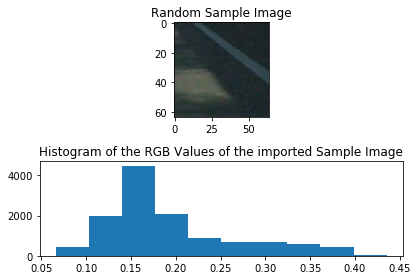

As you can See the imported image pixels has values between 0 and 1.

# Car images: 8792
/media/yousof/Volume/SDC/DataSets/p5/vehicles/GTI_Far/image0378.png
# NotCar images: 8968
/media/yousof/Volume/SDC/DataSets/p5/non-vehicles/Extras/extra1.png


In [2]:
car_dir_path = '/media/yousof/Volume/SDC/DataSets/p5/vehicles'
notcar_dir_path = '/media/yousof/Volume/SDC/DataSets/p5/non-vehicles'

cars_pth = glob.glob(car_dir_path + '*/*/*.png', recursive=True)
notcars_pth = glob.glob(notcar_dir_path + '*/*/*.png', recursive=True)
imgs = cars_pth + notcars_pth

rnd_idx = randint(0,len(imgs)-1)
test_img = mpimg.imread(imgs[rnd_idx])

plt.subplot(211)
plt.imshow(test_img)
plt.title('Random Sample Image')
plt.subplot(212)
plt.title('Histogram of the RGB Values of the imported Sample Image')
# undroll the image and draw the histogram to check the values of the imported image
plt.hist(test_img.ravel())
plt.tight_layout()
plt.show()
print('\x1b[31m'+'As you can See the imported image pixels has values between 0 and 1.'+'\x1b[0m')
print()

# Check if the import, using globe, is correct 
print('# Car images:',len(cars_pth))
print(cars_pth[0])
print('# NotCar images:',len(notcars_pth))
print(notcars_pth[0])

### Feature Extraction Helper

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 255)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(imgs,form = 'png', color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        if form == 'png':
            image = np.uint8(image*255)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Apply the Feature Extraction to Dataset &  Normalization of the Features

In [4]:
cspace='HLS'
sp_size = (32, 32)
hist_bins = 32
hist_orient_bin = 12
pixelPerCell = 8
cellPerBlock = 2
hogChannel = 0
with_spatial_feat = True
with_hist_feature = True
with_hog_feat = True

features_car = extract_features(cars_pth, form = 'png', color_space=cspace, spatial_size=sp_size,
                     hist_bins=hist_bins, orient=hist_orient_bin,
                     pix_per_cell=pixelPerCell, cell_per_block=cellPerBlock, hog_channel=hogChannel,
                     spatial_feat=with_spatial_feat, hist_feat=with_hist_feature, hog_feat=with_hog_feat)

features_notcar = extract_features(notcars_pth, form = 'png', color_space=cspace, spatial_size=sp_size,
                     hist_bins=hist_bins, orient=hist_orient_bin,
                     pix_per_cell=pixelPerCell, cell_per_block=2, hog_channel=hogChannel,
                     spatial_feat=with_spatial_feat, hist_feat=with_hist_feature, hog_feat=with_hog_feat)

# get the normalizer
print(np.isnan(np.array(features_car)).any())
all_features = features_car+features_notcar #
normalizer = StandardScaler().fit(all_features)
nor_features_car = normalizer.transform(features_car)
nor_features_notcar = normalizer.transform(features_notcar)

/media/yousof/Volume/SDC/Toolkits/anaconda3/envs/carnd_linelane/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


False


3072 96 2352.0


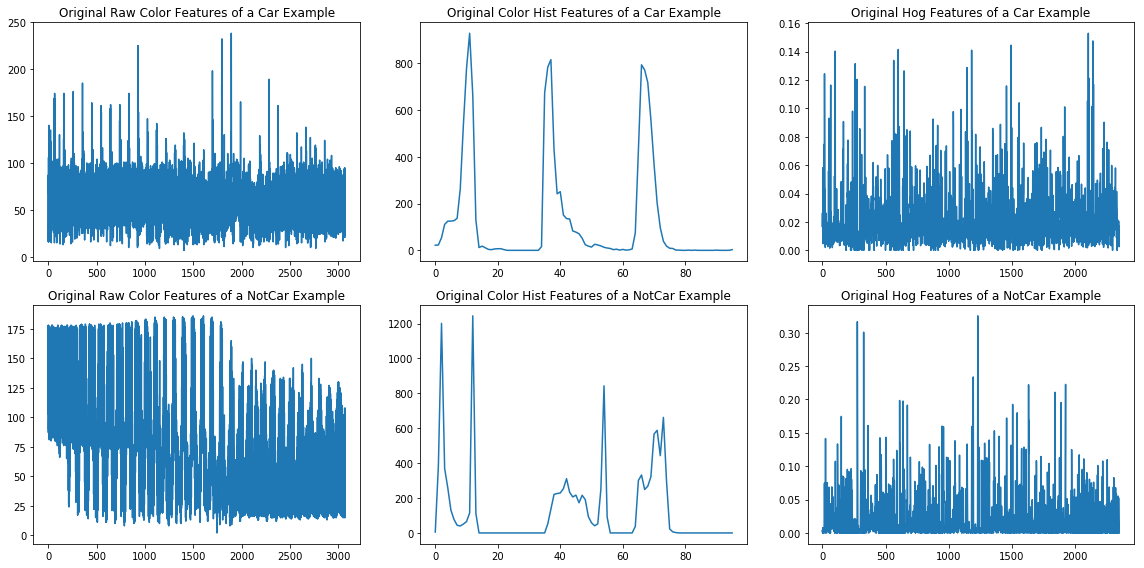

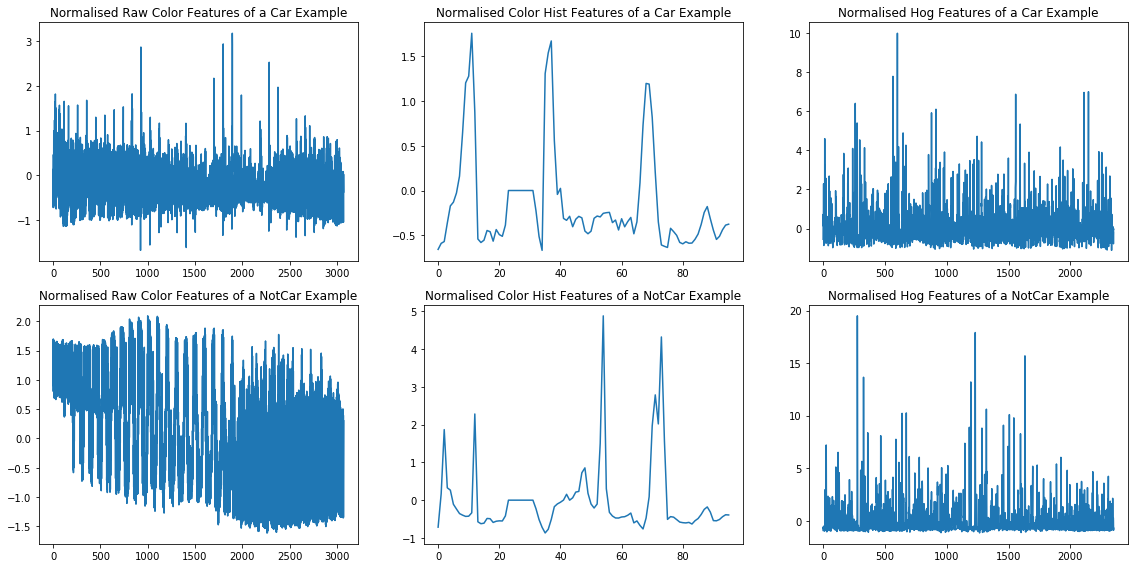

Normalizer Parameters: {'copy': True, 'with_std': True, 'with_mean': True}


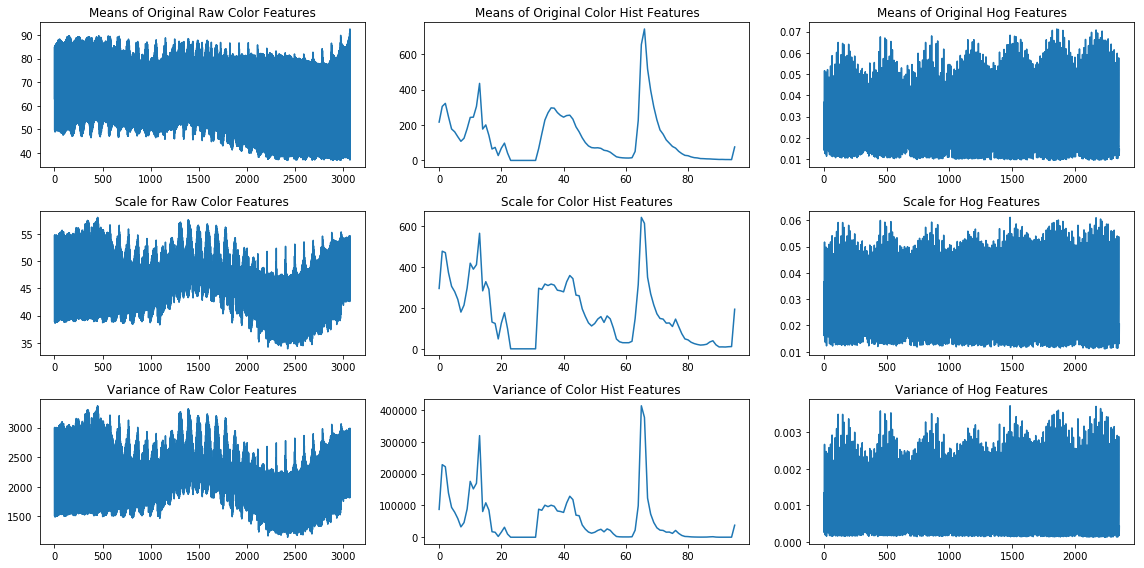

In [5]:
#calculate number of fearures related to each feature
n_bin_spatial_feat = sp_size[0]*sp_size[1]*3
n_color_hist_feat = hist_bins*3
n_hog_feat = ((64/pixelPerCell)-cellPerBlock+1) * ((64/pixelPerCell)-cellPerBlock+1) *\
                    cellPerBlock * cellPerBlock * hist_orient_bin
print(n_bin_spatial_feat,n_color_hist_feat,n_hog_feat)

# exploring the Normalization
id1 = 1452
id2 = 500
plt.figure(figsize=(16,8))
plt.subplot(231)
plt.title('Original Raw Color Features of a Car Example')
plt.plot(np.array(features_car[id1])[:n_bin_spatial_feat])
plt.subplot(232)
plt.title('Original Color Hist Features of a Car Example')
plt.plot(np.array(features_car[id1])[n_bin_spatial_feat:n_bin_spatial_feat+n_color_hist_feat])
plt.subplot(233)
plt.title('Original Hog Features of a Car Example')
plt.plot(np.array(features_car[id1])[n_bin_spatial_feat+n_color_hist_feat:])
plt.subplot(234)
plt.title('Original Raw Color Features of a NotCar Example')
plt.plot(np.array(features_notcar[id2])[:n_bin_spatial_feat])
plt.subplot(235)
plt.title('Original Color Hist Features of a NotCar Example')
plt.plot(np.array(features_notcar[id2])[n_bin_spatial_feat:n_bin_spatial_feat+n_color_hist_feat])
plt.subplot(236)
plt.title('Original Hog Features of a NotCar Example')
plt.plot(np.array(features_notcar[id2])[n_bin_spatial_feat+n_color_hist_feat:])
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,8))
plt.subplot(231)
plt.title('Normalised Raw Color Features of a Car Example')
plt.plot(np.array(nor_features_car[id1])[:n_bin_spatial_feat])
plt.subplot(232)
plt.title('Normalised Color Hist Features of a Car Example')
plt.plot(np.array(nor_features_car[id1])[n_bin_spatial_feat:n_bin_spatial_feat+n_color_hist_feat])
plt.subplot(233)
plt.title('Normalised Hog Features of a Car Example')
plt.plot(np.array(nor_features_car[id1])[n_bin_spatial_feat+n_color_hist_feat:])
plt.subplot(234)
plt.title('Normalised Raw Color Features of a NotCar Example')
plt.plot(np.array(nor_features_notcar[id2])[:n_bin_spatial_feat])
plt.subplot(235)
plt.title('Normalised Color Hist Features of a NotCar Example')
plt.plot(np.array(nor_features_notcar[id2])[n_bin_spatial_feat:n_bin_spatial_feat+n_color_hist_feat])
plt.subplot(236)
plt.title('Normalised Hog Features of a NotCar Example')
plt.plot(np.array(nor_features_notcar[id2])[n_bin_spatial_feat+n_color_hist_feat:])
plt.tight_layout()
plt.show()

print('Normalizer Parameters:',normalizer.get_params())

plt.figure(figsize=(16,8))
plt.subplot(331)
plt.title('Means of Original Raw Color Features')
plt.plot(np.array(normalizer.mean_)[:n_bin_spatial_feat])
plt.subplot(332)
plt.title('Means of Original Color Hist Features')
plt.plot(np.array(normalizer.mean_)[n_bin_spatial_feat:n_bin_spatial_feat+n_color_hist_feat])
plt.subplot(333)
plt.title('Means of Original Hog Features')
plt.plot(np.array(normalizer.mean_)[n_bin_spatial_feat+n_color_hist_feat:])
plt.subplot(334)
plt.title('Scale for Raw Color Features')
plt.plot(np.array(normalizer.scale_)[:n_bin_spatial_feat])
plt.subplot(335)
plt.title('Scale for Color Hist Features')
plt.plot(np.array(normalizer.scale_)[n_bin_spatial_feat:n_bin_spatial_feat+n_color_hist_feat])
plt.subplot(336)
plt.title('Scale for Hog Features')
plt.plot(np.array(normalizer.scale_)[n_bin_spatial_feat+n_color_hist_feat:])
plt.subplot(337)
plt.title('Variance of Raw Color Features')
plt.plot(np.array(normalizer.var_)[:n_bin_spatial_feat])
plt.subplot(338)
plt.title('Variance of Color Hist Features')
plt.plot(np.array(normalizer.var_)[n_bin_spatial_feat:n_bin_spatial_feat+n_color_hist_feat])
plt.subplot(339)
plt.title('Variance of Hog Features')
plt.plot(np.array(normalizer.var_)[n_bin_spatial_feat+n_color_hist_feat:])
plt.tight_layout()
plt.show()

### Preparing Data to train the classifier

In [6]:
# create the X, Y for classifier
X = np.vstack((nor_features_car, nor_features_notcar)).astype(np.float64)
y = np.hstack((np.ones(len(nor_features_car)), 
              np.zeros(len(nor_features_notcar))))


rand_state = np.random.randint(0, 100)
X,y = shuffle(X, y, random_state=rand_state)

# X_train, X_test, y_train, y_test = train_test_split(
#     scaled_X, y, test_size=0.2, random_state=rand_state)

### Train the Classifier with Different Parameters, Choose the Best, Evaluate and Save it

In [8]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters,verbose = 10,n_jobs = 4)
clf.fit(X, y)
print('best parameters:')
print(clf.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] C=1, kernel=linear ..............................................
[CV] C=1, kernel=linear ..............................................
[CV] C=1, kernel=linear ..............................................
[CV] C=1, kernel=rbf .................................................
[CV] ............... C=1, kernel=linear, score=0.967573, total= 3.3min
[CV] C=1, kernel=rbf .................................................
[CV] ............... C=1, kernel=linear, score=0.973142, total= 3.4min
[CV] C=1, kernel=rbf .................................................
[CV] ............... C=1, kernel=linear, score=0.970941, total= 3.5min
[CV] C=10, kernel=linear .............................................
[CV] .............. C=10, kernel=linear, score=0.967573, total= 3.3min
[CV] C=10, kernel=linear .............................................
[CV] .................. C=1, kernel=rbf, score=0.986658, total= 7.3min
[CV] C=10, kernel

[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed: 12.2min


[CV] .............. C=10, kernel=linear, score=0.973142, total= 3.5min
[CV] C=10, kernel=rbf ................................................
[CV] .............. C=10, kernel=linear, score=0.970941, total= 3.5min
[CV] C=10, kernel=rbf ................................................


[Parallel(n_jobs=4)]: Done   7 out of  12 | elapsed: 17.7min remaining: 12.7min


[CV] .................. C=1, kernel=rbf, score=0.988851, total= 7.6min
[CV] C=10, kernel=rbf ................................................
[CV] .................. C=1, kernel=rbf, score=0.990370, total= 7.6min


[Parallel(n_jobs=4)]: Done   9 out of  12 | elapsed: 18.0min remaining:  6.0min


[CV] ................. C=10, kernel=rbf, score=0.989022, total= 6.4min
[CV] ................. C=10, kernel=rbf, score=0.990203, total= 6.3min
[CV] ................. C=10, kernel=rbf, score=0.992228, total= 6.2min


[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 27.8min finished


best parameters:
{'C': 10, 'kernel': 'rbf'}


In [11]:
to_save = {"Classifier":clf}
pickle.dump( to_save, open( "classifier.p", "wb" ) )

In [16]:
# Load model from file
with open('classifier.p', "rb") as pc:
    to_load = pickle.load( pc )
    clf = to_load['Classifier']

idx = 200
# Predict new data with model loaded from disk
y_x2 = clf.best_estimator_.predict(X[idx])
print(y_x,y_x2,y[idx])

[ 1.] [ 1.] 1.0


/media/yousof/Volume/SDC/Toolkits/anaconda3/envs/carnd_linelane/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/media/yousof/Volume/SDC/Toolkits/anaconda3/envs/carnd_linelane/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
